Step 1: Load and Prepare Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet")

# Clean and engineer features
df['trip_duration'] = (pd.to_datetime(df['tpep_dropoff_datetime']) - pd.to_datetime(df['tpep_pickup_datetime'])).dt.total_seconds() / 60
df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 240)]

features = ['trip_distance', 'passenger_count', 'trip_duration']
target = 'fare_amount'
df = df[features + [target]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)


Step 2: Train XGBoost and LightGBM (A/B Test)

In [2]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

# XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_preds)

# LightGBM
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)
lgbm_mae = mean_absolute_error(y_test, lgbm_preds)

print(f"XGBoost MAE: {xgb_mae:.2f}")
print(f"LightGBM MAE: {lgbm_mae:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 2345588, number of used features: 3
[LightGBM] [Info] Start training from score 17.608048
XGBoost MAE: 2.91
LightGBM MAE: 2.94


Step 3: SHAP Explanations

c:\Users\CloudThat\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


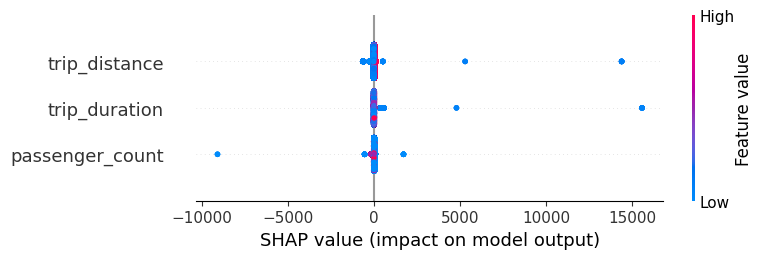

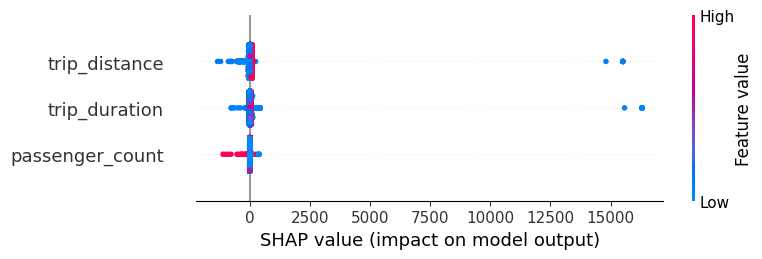

In [3]:
import shap

# SHAP for XGBoost
explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb(X_test)

shap.summary_plot(shap_values_xgb, X_test, show=True)

# SHAP for LightGBM
explainer_lgbm = shap.Explainer(lgbm_model)
shap_values_lgbm = explainer_lgbm(X_test)

shap.summary_plot(shap_values_lgbm, X_test, show=True)


Step 4: Model Cards

In [4]:
model_card_xgb = {
    "name": "XGBoost NYC Taxi Fare Model",
    "version": "1.0",
    "framework": "XGBoost",
    "mae": xgb_mae,
    "features": features,
    "explanation": "SHAP summary plot included",
    "dataset": "NYC Yellow Taxi Jan 2025",
    "notes": "Predicts fare amount based on trip features"
}

model_card_lgbm = {
    "name": "LightGBM NYC Taxi Fare Model",
    "version": "1.0",
    "framework": "LightGBM",
    "mae": lgbm_mae,
    "features": features,
    "explanation": "SHAP summary plot included",
    "dataset": "NYC Yellow Taxi Jan 2025",
    "notes": "Predicts fare amount based on trip features"
}

print("XGBoost Model Card:", model_card_xgb)
print("LightGBM Model Card:", model_card_lgbm)


XGBoost Model Card: {'name': 'XGBoost NYC Taxi Fare Model', 'version': '1.0', 'framework': 'XGBoost', 'mae': 2.9093888932346874, 'features': ['trip_distance', 'passenger_count', 'trip_duration'], 'explanation': 'SHAP summary plot included', 'dataset': 'NYC Yellow Taxi Jan 2025', 'notes': 'Predicts fare amount based on trip features'}
LightGBM Model Card: {'name': 'LightGBM NYC Taxi Fare Model', 'version': '1.0', 'framework': 'LightGBM', 'mae': 2.9387571114242954, 'features': ['trip_distance', 'passenger_count', 'trip_duration'], 'explanation': 'SHAP summary plot included', 'dataset': 'NYC Yellow Taxi Jan 2025', 'notes': 'Predicts fare amount based on trip features'}
